2198 751
Proportion of train_set : 0.75%
Proportion of valid_set : 0.25%


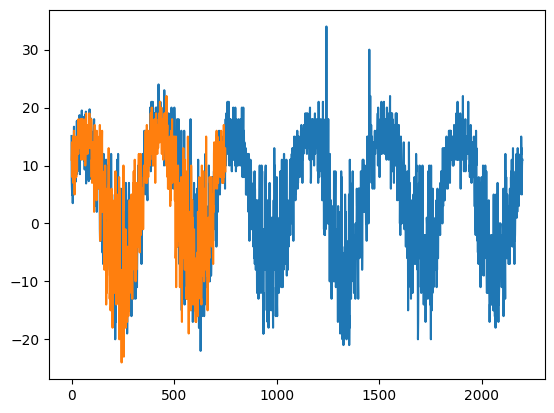

In [1]:
from experiment import Experiment
from utils.plot import plot_predictions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


solar_power = pd.read_csv('./data/solarpanelspower/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0':'date'}).set_index('date')
def generate_data(num_steps: int, interval: float = 0.1) -> None:
    x = np.linspace(0, num_steps * interval, num_steps)
    y = np.sin(x) + np.random.normal(0, 0.1, x.shape)
    return y


# solar_power['Elec_kW'] =generate_data(len(solar_power))


split_date = '2017-10-31'
train_set = solar_power[:split_date]
valid_set = solar_power[split_date:]
print(len(train_set), len(valid_set))
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(solar_power)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(solar_power)))
# print('Proportion of test_set : {:.2f}%'.format(len(test_set)/len(solar_power)))
plt.plot(train_set.Elec_kW.values);plt.plot(valid_set.Elec_kW.values)

---
#### SimpleTransformer (Medium Article)

In [2]:
import math
import time
from torch.utils.data import DataLoader
from torch import nn
import torch


# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html,
# only modified to account for "batch first".
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Adds positional encoding to the given tensor.

        Args:
            x: tensor to add PE to [bs, seq_len, embed_dim]

        Returns:
            torch.Tensor: tensor with PE [bs, seq_len, embed_dim]
        """
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


class VanillaTransformer(torch.nn.Module):
    def __init__(self, model_params: dict):
        super(VanillaTransformer, self).__init__()
        # Set model vars
        expected_vars = ['in_features','d_model','block_size',
                         'encoder_nheads','encoder_nlayers','encoder_dropout',
                         'decoder_nheads','decoder_nlayers','decoder_dropout',
                         'feedforward_dim','forecast_horizon','seed','mapping_dim']
        for v in expected_vars:
            assert v in model_params.keys(), f'Key "{v}" is missing on params dict'
            vars(self)[v] = model_params[v]
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, 
        num_layers, dim_feedforward, block_size
    ) -> None:
        """Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        self.train_loss_history = []
        self.validation_loss_history = []
        #
        # self.positional_encoding = PositionalEncoding(embed_dim)
        self.pos_emb = nn.Embedding(num_embeddings=block_size, embedding_dim=self.d_model)

        self.encoder_embedding = torch.nn.Linear(in_features=in_dim, out_features=embed_dim)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim, out_features=embed_dim)
        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)

        self.transformer = torch.nn.Transformer(
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            d_model=embed_dim,
            dim_feedforward=dim_feedforward,
            batch_first=True,
        )
        self.mask = True
    def is_transformer(self, ): return True

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        B, T, C = src.shape
        # if self.train:# Add noise to decoder inputs during training
        #     tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)
        # Embed encoder input and add positional encoding [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = src +  self.pos_emb(torch.arange(src.shape[1]).to('cuda'))# (B, T) --> (B, T, Emb) = self.positional_encoding(src)

        # Generate mask to avoid attention to future outputs.[tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
        # Embed decoder input and add positional encoding. [bs, tgt_seq_len, embed_dim]
        tgt = self.decoder_embedding(tgt)
        tgt = tgt +  self.pos_emb(torch.arange(tgt.shape[1]).to('cuda'))#self.positional_encoding(tgt)

        # Get prediction from transformer and map to output dimension.[bs, tgt_seq_len, embed_dim]
        pred = self.transformer(src, tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)
        return pred
    
    @torch.no_grad()
    def validate(self, data):
        self.eval()
        val_loader = DataLoader(data, batch_size=1024, shuffle=False)
        loss_fn = nn.MSELoss()
        val_loss = 0.0
        #
        with torch.no_grad():
            for enc_x, dec_x, tgt_y in val_loader:
                pred_y = self(enc_x, dec_x)
                val_loss += loss_fn(pred_y, tgt_y)
        val_loss = val_loss/len(val_loader)
        self.train()
        return val_loss
    
    @torch.no_grad()
    def predict(self, src, forecast_horizon):
        self.eval()
        src = src[:, -self.block_size:, :]
        output = src[0, -1].clone().view(1, 1, 1) # first value
        for i in range(forecast_horizon):
            y_next = self(src, output[:, -self.block_size:, :])
            y_next = y_next[:, -1:, :]
            # concatenate in each batch along the time dimension
            output = torch.concat((output, y_next), dim=1)
        return output[:, 1: ,: ] # remove first value (copy from last history step)

    def fit(self, conf):
        self.train()
        expected_vars = ['epochs','lr','batch_size','train_dataset','validate_freq']
        for v in expected_vars:
            assert v in conf.keys(), f'Key "{v}" is missing on params dict'
        #
        epochs = conf['epochs']
        verbose = conf['verbose']
        train_dataset = conf['train_dataset']
        val_dataset = conf.get('train_dataset',None)
        validate_freq = conf.get('validate_freq',10)
        #
        optimizer = torch.optim.AdamW(self.parameters(), lr=conf['lr'])
        loss_fn = nn.MSELoss()
        train_loader = DataLoader(train_dataset, batch_size=conf['batch_size'], shuffle=True)
        for epoch_i in range(epochs):
            timr = time.time()
            epoch_loss = .0
            val_loss = -1
            for enc_x, dec_x, tgt_y in train_loader:
                optimizer.zero_grad() # current batch zero-out the loss
                pred_y = self(enc_x, dec_x)
                loss = loss_fn(pred_y, tgt_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss        
            # end epoch
            epoch_loss = epoch_loss/len(train_loader)
            self.train_loss_history.append(epoch_loss.to('cpu').detach().numpy())
            to_validate = (val_dataset is not None) and (epoch_i % validate_freq == 0)
            if verbose:
                if to_validate: 
                    val_loss = self.validate(val_dataset)
                    self.validation_loss_history.append(val_loss.to('cpu').detach().numpy())
                    timr = time.time() - timr
                    torch.save(self, f'former_{epoch_i}.model')
                    print(f'Epoch {epoch_i+1}/{epochs} [{timr:.3f}secs] -> Train loss: {epoch_loss:.5f} | Validation loss: {val_loss:.5f}')
                else: 
                    timr = time.time() - timr
                    print(f'Epoch {epoch_i+1}/{epochs} [{timr:.3f}secs] -> Train loss: {epoch_loss:.5f}')
        torch.save(self, f'former_last.model')


block_size = 256
fh = 256
model_params={
    'in_dim': 1, 
    'out_dim':1, 
    'embed_dim': 16, 
    'num_heads': 4, 
    'num_layers': 4,
    'dim_feedforward':128,
    'block_size':block_size
}
torch.cuda.empty_cache()
import gc
gc.collect()
model = TransformerWithPE(**model_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Num of weights:',pytorch_total_params)
# print(model)

Num of weights: 51857


In [3]:
from sklearn.preprocessing import MinMaxScaler
exp = Experiment(
    {
        # Model
        'model': model,
        'input_len':block_size,
        'feature_dim':1,
        'forecast_horizon':fh,
        # Data
        'frequency':'daily',
        'scaler': MinMaxScaler((-1,1)),
        'decompose': False, #detrend and de-sazonalize
        'freq':1,
        # Others
        'device':'cuda',
        'verbose':True,
    })
#

exp.set_dataset(linear_serie=train_set.Elec_kW.values, train=True)
exp.set_dataset(linear_serie=valid_set.Elec_kW.values, validation=True)

#
exp.train({
    'epochs':512,
    'lr':1e-3,
    'batch_size':512,
    'validate_freq':20,
    'verbose':True,
})

Scaler FIT
Epoch 1/512 [4.124secs] -> Train loss: 0.24238 | Validation loss: 0.12973
Epoch 2/512 [2.935secs] -> Train loss: 0.14805
Epoch 3/512 [2.920secs] -> Train loss: 0.14628
Epoch 4/512 [2.704secs] -> Train loss: 0.13693
Epoch 5/512 [2.785secs] -> Train loss: 0.13763
Epoch 6/512 [2.808secs] -> Train loss: 0.13289
Epoch 7/512 [2.919secs] -> Train loss: 0.13134
Epoch 8/512 [2.976secs] -> Train loss: 0.12984
Epoch 9/512 [2.744secs] -> Train loss: 0.12684
Epoch 10/512 [2.703secs] -> Train loss: 0.12472
Epoch 11/512 [2.751secs] -> Train loss: 0.12082
Epoch 12/512 [2.754secs] -> Train loss: 0.11621
Epoch 13/512 [2.711secs] -> Train loss: 0.11106
Epoch 14/512 [2.730secs] -> Train loss: 0.10761
Epoch 15/512 [2.778secs] -> Train loss: 0.10448
Epoch 16/512 [2.758secs] -> Train loss: 0.10002
Epoch 17/512 [2.697secs] -> Train loss: 0.09681
Epoch 18/512 [2.690secs] -> Train loss: 0.09363
Epoch 19/512 [2.757secs] -> Train loss: 0.08979
Epoch 20/512 [2.766secs] -> Train loss: 0.08695
Epoch 21/51

In [6]:
fh = block_size*2
ts = train_set.Elec_kW.values[-block_size:]
ts_future = valid_set.Elec_kW.values[:fh*5]
#
ts = exp.preprocess(ts) # TODO add ts copy 
output = exp.model.predict(ts, fh)
# rescale and add trend, etc..
output = exp.posprocess(output)
exp.print_metrics(ts_future[:fh], output[:fh])
plot_predictions(train_set.Elec_kW.values, ts_future, output)
# MSE: 45.0453 | MAPE: 285586443206656.8125 | sMAPE: 0.6928

MSE: 48.6110 | MAPE: 341926203097088.7500 | sMAPE: 0.6985


In [5]:
# fh = block_size*2
# ts = train_set.Elec_kW.values[-block_size:]
# ts_future = valid_set.Elec_kW.values[:fh*5]
# #
# ts = exp.preprocess(ts) # TODO add ts copy 
# output = exp.model.predict(ts, fh)
# # rescale and add trend, etc..
# output = exp.posprocess(output)
# exp.print_metrics(ts_future[:fh], output[:fh])
# plot_predictions(train_set.Elec_kW.values, ts_future, output)
    

---